In [1]:
import ee
import geemap
import xarray as xr



In [2]:
!pip install xee
import xee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.8 MB/s eta 0:00:00


In [3]:
ee.Authenticate()
ee.Initialize(project = 'ee-lavibas23', opt_url = 'https://earthengine-highvolume.googleapis.com')

In [4]:
map = geemap.Map(basemap = 'SATELLITE')
map


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [53]:
roi = map.draw_last_feature.geometry()

In [54]:
landsat = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .merge(ee.ImageCollection("LANDSAT/LC09/C02/T1_L2"))
    .filterBounds(roi)
    .filterDate('2024','2025')
    .sort('system:time_start')
)

In [55]:
def water_index(img):
  qa = img.select('QA_PIXEL')
  cirrus = qa.bitwiseAnd(1 << 2).neq(0)
  cloud = qa.bitwiseAnd(1 << 3).neq(0)
  shadow = qa.bitwiseAnd(1 << 4).neq(0)
  mask = cirrus.Or(cloud).Or(shadow).Not()
  bands = img.select('SR.*').multiply(2.75e-05).add(-0.2).updateMask(mask)
  if index_name == 'ndwi':
    ndwi = bands.normalizedDifference(['SR_B3', 'SR_B5']).rename('ndwi')
    return ndwi.copyProperties(img, ['system:time_start'])
  elif index_name  == 'andwi':
    andwi = bands.expression('(blue + green + red - nir - swir1 - swir2)/(blue + green + red + nir + swir1 + swir2)',{
        'blue': bands.select('SR_B2'),
        'green': bands.select('SR_B3'),
        'red': bands.select('SR_B4'),
        'nir': bands.select('SR_B5'),
        'swir1': bands.select('SR_B6'),
        'swir2': bands.select('SR_B7')
    }).rename('andwi')
    return andwi.copyProperties(img, ['system:time_start'])

In [56]:
index_name = 'ndwi'
ndwi = landsat.map(water_index)

In [57]:
index_name = 'andwi'
andwi = landsat.map(water_index)


In [74]:
ndwi_ds = xr.open_dataset(
    ndwi,
    engine = 'ee',
    crs = 'EPSG:4326',
    scale = 0.0001,
    geometry = roi
)


In [77]:
andwi_ds = xr.open_dataset(
    andwi,
    engine = 'ee',
    crs = 'EPSG:4326',
    scale = 0.0001,
    geometry = roi
)

In [78]:
ndwi_mean = ndwi_ds.mean('time')

In [79]:
andwi_mean = andwi_ds.mean('time')

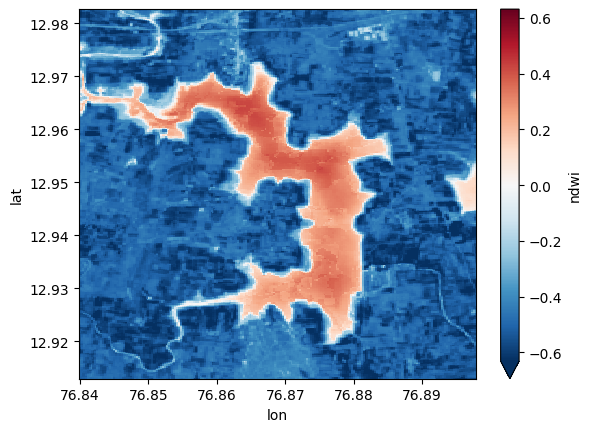

In [76]:
ndwi_mean.ndwi.plot(x = 'lon', y = 'lat', robust = True)

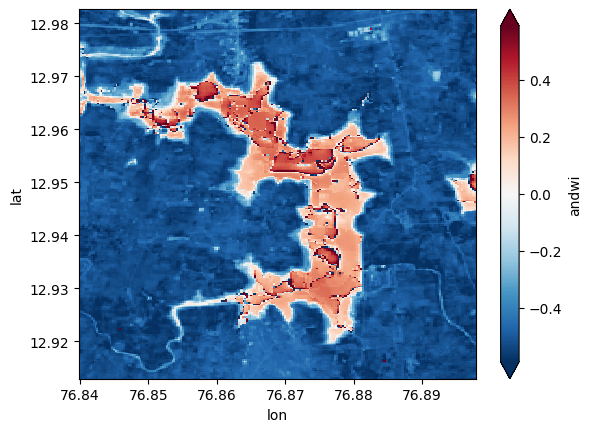

In [80]:
andwi_mean.andwi.plot(x = 'lon', y = 'lat', robust = True)

In [81]:
ndwi_monthly  = ndwi_ds.resample(time = 'M').mean('time')
andwi_monthly = andwi_ds.resample(time = 'M').mean('time')

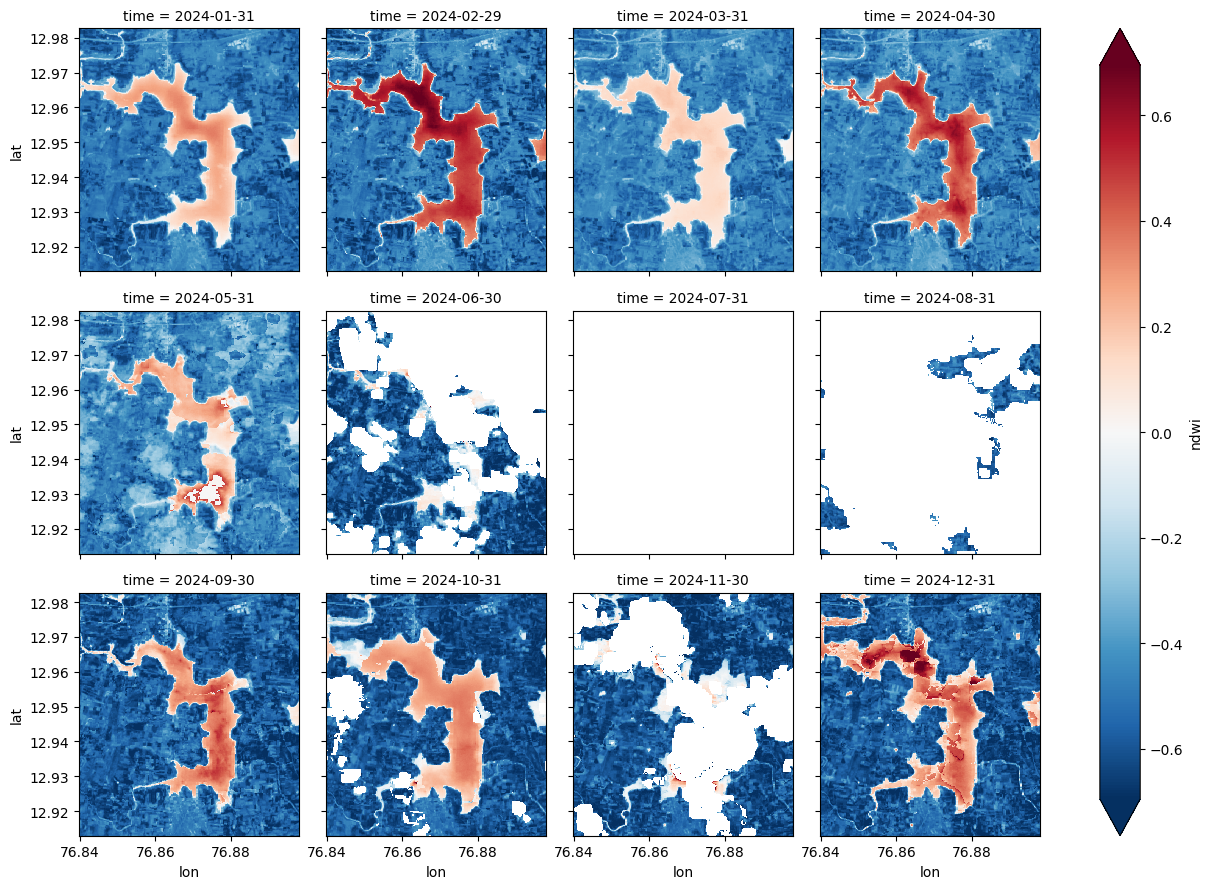

In [82]:
ndwi_monthly.ndwi.plot(x = 'lon', y = 'lat', col = 'time', robust = True, col_wrap = 4)

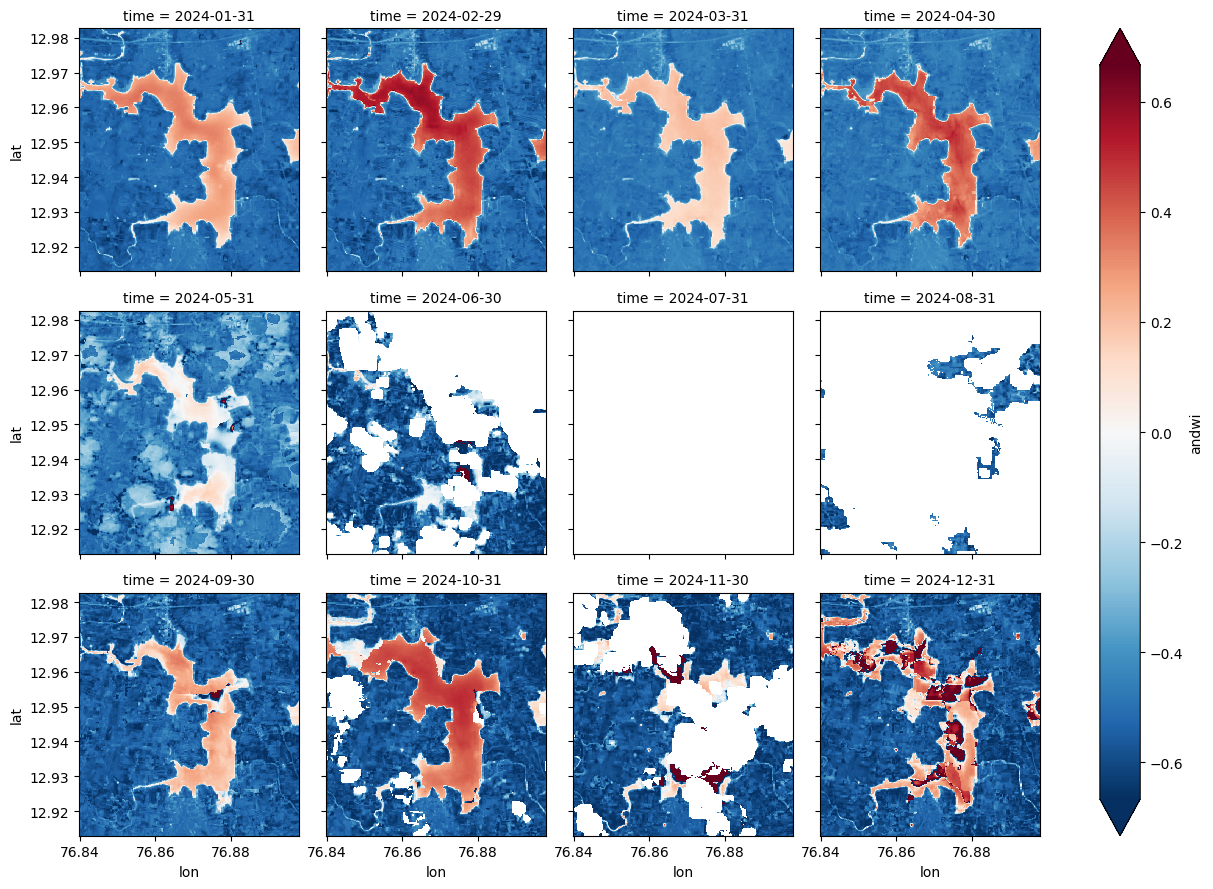

In [83]:
andwi_monthly.andwi.plot(x = 'lon', y = 'lat', col = 'time', robust = True, col_wrap = 4)